In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
#%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import pandas as pd
import numpy as np
from Color import *
from operator import truediv, sub
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter

# Matplotlib font configuration
from MatplotlibFonts import *

# Helpers
from BrokenPlot import *

# Change the font size
rcParams.update({"font.size": 13})

In [10]:
%reload_ext autoreload
from BenchmarkConfiguration import *
from Color import *

In [11]:
RESULT_DIR='../benchmarks/logs'

In [12]:
Benchmarks = [
    'coremark',
    'picojpeg',
    'aes',
    'crc',
    'dijkstra',
    'sha',
]

BaseConfigurations = [
    'nacho_naive',
    'nacho_pw',
    'nacho_stcont',
    'nacho_pw_st',
    'nacho_pw_stcont',
    'nacho_clank',
    'prowl',
    'clank',
    'plain_c'
]

CacheConfigurations = [
    'None',
    '256-2',
    '256-4',
    '512-2',
    '512-4',
    '1024-2',
    '1024-4'
]

In [13]:
# Load all the results into a dictionary

def loadResult(Results, benchmark, config, cache, power_failure_params='-0-0', midfix='-uninstrumented-run-', opt_lvl="-O3"):
    if cache == '0-0':
        filename = RESULT_DIR + '/' + benchmark + midfix + config + power_failure_params + opt_lvl + '-final'
    else:
        filename = RESULT_DIR + '/' + benchmark + midfix + config + '-' + cache + power_failure_params + opt_lvl + '-final'
    
    if config not in Results[benchmark]:
        Results[benchmark][config] = {}
    
    # Add the results
    if (power_failure_params == '-0-0' or power_failure_params == '') and opt_lvl == "-O3":
        Results[benchmark][config][cache] = dict(pd.read_csv(filename, delimiter=":", header = None).values)
    elif (power_failure_params == '-0-0' or power_failure_params == '') and opt_lvl != "-O3":
        Results[benchmark][config][cache+opt_lvl] = dict(pd.read_csv(filename, delimiter=":", header = None).values)
    else:
        Results[benchmark][config][cache + power_failure_params + "-final"] = dict(pd.read_csv(filename, delimiter=":", header = None).values)

Results = {}


def getPostfix(pfc, checkpoint_freq=-1):
    if checkpoint_freq == -1:
        checkpoint_freq = pfc // 2
    return '-' + str(checkpoint_freq) + '-' + str(pfc)



power_failure_cycles = [
    250000,
    500000,
    2500000,
    5000000,
    25000000,
]
power_failure_cache = '512-2'

for benchmark in Benchmarks:
    Results[benchmark] = {}

    # Load Nacho results
    nacho_caches = [
        '256-2',
        #'256-4',
        '512-2',
        #'512-4',
        #'1024-2',
        #'1024-4'
    ]
    for cache in nacho_caches:
        loadResult(Results, benchmark, 'nacho_naive', cache)
        loadResult(Results, benchmark, 'nacho_pw', cache)
        loadResult(Results, benchmark, 'nacho_stcont', cache)
        loadResult(Results, benchmark, 'nacho_pw_st', cache)
        loadResult(Results, benchmark, 'nacho_pw_stcont', cache)
        loadResult(Results, benchmark, 'nacho_clank', cache)

    # Load Prowl results
    prowl_caches = [
        '256-2',
        '512-2',
        #'1024-2',
    ]
    for cache in prowl_caches:
        loadResult(Results, benchmark, 'prowl', cache)

    # Load Clank results
    loadResult(Results, benchmark, 'clank', '0-0')

    # Load plain C results
    loadResult(Results, benchmark, 'plain_c', '0-0', '')

    # ReplayCache comparison
    loadResult(Results, benchmark, 'replay_cache_baseline', '8192-2')

    # Load Prowl results
    replay_cache_caches = [
        '256-2',
        '512-2',
        # '1024-2',
        '8192-2'
    ]
    for cache in replay_cache_caches:
        loadResult(Results, benchmark, 'replay_cache', cache, midfix="-replay-cache-run-")

    for pfc in power_failure_cycles:
        loadResult(Results, benchmark, 'clank', '0-0', getPostfix(pfc))
        loadResult(Results, benchmark, 'prowl', power_failure_cache, getPostfix(pfc))
        loadResult(Results, benchmark, 'replay_cache', power_failure_cache, getPostfix(pfc, 0), "-replay-cache-run-")
        loadResult(Results, benchmark, 'nacho_pw_stcont', power_failure_cache, getPostfix(pfc))

    opt_levels = [
        '-Os',
        '-O1',
        '-O2'
    ]
    for opt_level in opt_levels:
        loadResult(Results, benchmark, 'plain_c', '0-0', '', opt_lvl=opt_level)
        loadResult(Results, benchmark, 'clank', '0-0', opt_lvl=opt_level)
        loadResult(Results, benchmark, 'prowl', power_failure_cache, opt_lvl=opt_level)
        loadResult(Results, benchmark, 'replay_cache', power_failure_cache, midfix="-replay-cache-run-", opt_lvl=opt_level)
        loadResult(Results, benchmark, 'nacho_pw_stcont', power_failure_cache, opt_lvl=opt_level)

Results['picojpeg']['clank']


{'0-0': {'cache_miss': 0,
  'cache_hit': 0,
  'cache_read': 0,
  'cache_write': 0,
  'cache_cuckoo': 0,
  'cache_checkpoint': 0,
  'nvm_reads_no_cache': 0,
  'nvm_writes_no_cache': 0,
  'nvm_reads': 31812193,
  'nvm_writes': 56903532,
  'checkpoint': 199204,
  'checkpoint_war': 199204,
  'checkpoint_dirty': 0,
  'checkpoint_period': 0,
  'checkpoint_max_cycles': 0,
  'restore': 0,
  'hints_given': 0,
  'max_dirty_ratio': 0,
  'cuckoo_iter': 0,
  'cycles': 207064232,
  'on_duration_cycles': 0,
  'checkpoint_period_cycles': 0},
 '0-0-125000-250000-final': {'cache_miss': 0,
  'cache_hit': 0,
  'cache_read': 0,
  'cache_write': 0,
  'cache_cuckoo': 0,
  'cache_checkpoint': 0,
  'nvm_reads_no_cache': 0,
  'nvm_writes_no_cache': 0,
  'nvm_reads': 31930973,
  'nvm_writes': 56907700,
  'checkpoint': 199204,
  'checkpoint_war': 199204,
  'checkpoint_dirty': 0,
  'checkpoint_period': 0,
  'checkpoint_max_cycles': 0,
  'restore': 829,
  'hints_given': 0,
  'max_dirty_ratio': 0,
  'cuckoo_iter': 0

# Execution Time

In [47]:
# Benchmark plots with execution time
# Plot each benchmark, each config, two cache configs (256, 512)

PlotBenchmarks = Benchmarks
PlotConfigurations = BaseConfigurations

EntryToPlot='cycles'

def getPlotData(pd, benchmark, config, cache, postfix='', opt_level=''):

    if postfix == '' and opt_level == '':
        key = config+'-'+cache
    elif postfix == '' and opt_level != '':
        key = config+'-'+cache+opt_level
    else:
        key = config+'-'+cache+postfix+"-final"

    if key not in pd[benchmark]:
        pd[benchmark][key] = {}

    
    if postfix == '' and opt_level == '':
        pd[benchmark][key] = Results[benchmark][config][cache][EntryToPlot]
    elif postfix == '' and opt_level != '':
        pd[benchmark][key] = Results[benchmark][config][cache+opt_level][EntryToPlot]
    else:
        pd[benchmark][key] = Results[benchmark][config][cache+postfix+"-final"][EntryToPlot]
    

PlotData = {}
PlotDataPF250000 = {}
PlotDataPF500000 = {}
PlotDataPF2500000 = {}
PlotDataPF5000000 = {}
PlotDataPF25000000 = {}
PlotDataOs = {}
PlotDataO1 = {}
PlotDataO2 = {}
for benchmark in PlotBenchmarks:
    PlotData[benchmark] = {}
    PlotDataPF250000[benchmark] = {}
    PlotDataPF500000[benchmark] = {}
    PlotDataPF2500000[benchmark] = {}
    PlotDataPF5000000[benchmark] = {}
    PlotDataPF25000000[benchmark] = {}
    PlotDataOs[benchmark] = {}
    PlotDataO1[benchmark] = {}
    PlotDataO2[benchmark] = {}
    
    getPlotData(PlotData, benchmark, 'plain_c', '0-0')
    getPlotData(PlotData, benchmark, 'clank', '0-0')
    getPlotData(PlotData, benchmark, 'prowl', '256-2')
    getPlotData(PlotData, benchmark, 'nacho_pw_stcont', '256-2')
    getPlotData(PlotData, benchmark, 'nacho_clank', '256-2')
    getPlotData(PlotData, benchmark, 'replay_cache', '256-2')
    getPlotData(PlotData, benchmark, 'prowl', '512-2')
    getPlotData(PlotData, benchmark, 'nacho_pw_stcont', '512-2')
    getPlotData(PlotData, benchmark, 'nacho_clank', '512-2')
    getPlotData(PlotData, benchmark, 'replay_cache', '512-2')

    getPlotData(PlotDataPF250000, benchmark, 'plain_c', '0-0')
    getPlotData(PlotDataPF500000, benchmark, 'plain_c', '0-0')
    getPlotData(PlotDataPF2500000, benchmark, 'plain_c', '0-0')
    getPlotData(PlotDataPF5000000, benchmark, 'plain_c', '0-0')
    getPlotData(PlotDataPF25000000, benchmark, 'plain_c', '0-0')
    
    getPlotData(PlotDataPF250000, benchmark, 'clank', '0-0', getPostfix(250000))
    getPlotData(PlotDataPF250000, benchmark, 'prowl', power_failure_cache, getPostfix(250000))
    getPlotData(PlotDataPF250000, benchmark, 'replay_cache', power_failure_cache, getPostfix(250000, 0))
    getPlotData(PlotDataPF250000, benchmark, 'nacho_pw_stcont', power_failure_cache, getPostfix(250000))
    
    getPlotData(PlotDataPF500000, benchmark, 'clank', '0-0', getPostfix(500000))
    getPlotData(PlotDataPF500000, benchmark, 'prowl', power_failure_cache, getPostfix(500000))
    getPlotData(PlotDataPF500000, benchmark, 'replay_cache', power_failure_cache, getPostfix(500000, 0))
    getPlotData(PlotDataPF500000, benchmark, 'nacho_pw_stcont', power_failure_cache, getPostfix(500000))
    
    getPlotData(PlotDataPF2500000, benchmark, 'clank', '0-0', getPostfix(2500000))
    getPlotData(PlotDataPF2500000, benchmark, 'prowl', power_failure_cache, getPostfix(2500000))
    getPlotData(PlotDataPF2500000, benchmark, 'replay_cache', power_failure_cache, getPostfix(2500000, 0))
    getPlotData(PlotDataPF2500000, benchmark, 'nacho_pw_stcont', power_failure_cache, getPostfix(2500000))
    
    getPlotData(PlotDataPF5000000, benchmark, 'clank', '0-0', getPostfix(5000000))
    getPlotData(PlotDataPF5000000, benchmark, 'prowl', power_failure_cache, getPostfix(5000000))
    getPlotData(PlotDataPF5000000, benchmark, 'replay_cache', power_failure_cache, getPostfix(5000000, 0))
    getPlotData(PlotDataPF5000000, benchmark, 'nacho_pw_stcont', power_failure_cache, getPostfix(5000000))
    
    getPlotData(PlotDataPF25000000, benchmark, 'clank', '0-0', getPostfix(25000000))
    getPlotData(PlotDataPF25000000, benchmark, 'prowl', power_failure_cache, getPostfix(25000000))
    getPlotData(PlotDataPF25000000, benchmark, 'replay_cache', power_failure_cache, getPostfix(25000000, 0))
    getPlotData(PlotDataPF25000000, benchmark, 'nacho_pw_stcont', power_failure_cache, getPostfix(25000000))

    getPlotData(PlotDataOs, benchmark, 'plain_c', '0-0', opt_level="-Os")
    getPlotData(PlotDataOs, benchmark, 'clank', '0-0', opt_level="-Os")
    getPlotData(PlotDataOs, benchmark, 'prowl', power_failure_cache, opt_level="-Os")
    getPlotData(PlotDataOs, benchmark, 'replay_cache', power_failure_cache, opt_level="-Os")
    getPlotData(PlotDataOs, benchmark, 'nacho_pw_stcont', power_failure_cache, opt_level="-Os")

    getPlotData(PlotDataO1, benchmark, 'plain_c', '0-0', opt_level="-O1")
    getPlotData(PlotDataO1, benchmark, 'clank', '0-0', opt_level="-O1")
    getPlotData(PlotDataO1, benchmark, 'prowl', power_failure_cache, opt_level="-O1")
    getPlotData(PlotDataO1, benchmark, 'replay_cache', power_failure_cache, opt_level="-O1")
    getPlotData(PlotDataO1, benchmark, 'nacho_pw_stcont', power_failure_cache, opt_level="-O1")

    getPlotData(PlotDataO2, benchmark, 'plain_c', '0-0', opt_level="-O2")
    getPlotData(PlotDataO2, benchmark, 'clank', '0-0', opt_level="-O2")
    getPlotData(PlotDataO2, benchmark, 'prowl', power_failure_cache, opt_level="-O2")
    getPlotData(PlotDataO2, benchmark, 'replay_cache', power_failure_cache, opt_level="-O2")
    getPlotData(PlotDataO2, benchmark, 'nacho_pw_stcont', power_failure_cache, opt_level="-O2")
    
    
#PlotData
PlotDataDF = pd.DataFrame.from_dict(PlotData)

PlotDataDFPF250000 = pd.DataFrame.from_dict(PlotDataPF250000)
PlotDataDFPF500000 = pd.DataFrame.from_dict(PlotDataPF500000)
PlotDataDFPF2500000 = pd.DataFrame.from_dict(PlotDataPF2500000)
PlotDataDFPF5000000 = pd.DataFrame.from_dict(PlotDataPF5000000)
PlotDataDFPF25000000 = pd.DataFrame.from_dict(PlotDataPF25000000)

PlotDataDFOs = pd.DataFrame.from_dict(PlotDataOs)
PlotDataDFO1 = pd.DataFrame.from_dict(PlotDataO1)
PlotDataDFO2 = pd.DataFrame.from_dict(PlotDataO2)

PlotDataDF
# PlotDataDF

,coremark,picojpeg,aes,crc,dijkstra,sha
plain_c-0-0,2928751.0,22634204.0,8130171.0,21761.0,58583596.0,22735380.0
clank-0-0,43450159.0,207064232.0,123446817.0,244553.0,139161220.0,44149134.0
prowl-256-2,17972803.0,138691688.0,15559277.0,86975.0,146658092.0,94557098.0
nacho_pw_stcont-256-2,6062757.0,86778326.0,11041769.0,35519.0,137828690.0,44425368.0
nacho_clank-256-2,5096241.0,82236352.0,10926105.0,35519.0,135695526.0,44236290.0
replay_cache-256-2,9183014.0,79291911.0,20620151.0,59541.0,171570745.0,74421767.0
prowl-512-2,12297571.0,92456558.0,14269989.0,53397.0,134827944.0,70357802.0
nacho_pw_stcont-512-2,3381285.0,75538602.0,9357357.0,29699.0,129145928.0,36539164.0
nacho_clank-512-2,3329465.0,73391416.0,9242339.0,29699.0,127976956.0,28705958.0
replay_cache-512-2,7956663.0,76238200.0,19764791.0,59271.0,167408939.0,67989527.0


In [15]:
# Remove the "base" cost of plain-c
#dfb = PlotDataDF.copy()

#base_cost_config = 'plain_c-0-0'

#for benchmark in Benchmarks:
#    base_cost_value = dfb[benchmark][base_cost_config]
#    dfb[benchmark] = dfb[benchmark]-base_cost_value

# Remove the plain_c entry
#dfb = dfb.drop('plain_c-0-0')

In [16]:
# Normalize
dfn = PlotDataDF.copy()

norm_config = 'plain_c-0-0'

for benchmark in Benchmarks:
    norm_value = dfn[benchmark][norm_config]
    dfn[benchmark] = dfn[benchmark]/norm_value

adfn = dfn.copy()
dfn = dfn.drop('plain_c-0-0')

# Rename
dfn = dfn.rename(columns=BenchmarkNameMap)
dfn

,CoreMark,picojpeg,Tiny AES,CRC,Dijkstra,SHA
clank-0-0,14.835730,9.148289,15.183791,11.238132,2.375430,1.941869
prowl-256-2,6.136678,6.127527,1.913770,3.996829,2.503399,4.159029
nacho_pw_stcont-256-2,2.070083,3.833946,1.358123,1.632232,2.352684,1.954019
nacho_clank-256-2,1.740073,3.633278,1.343896,1.632232,2.316272,1.945703
replay_cache-256-2,3.135471,3.503190,2.536251,2.736133,2.928648,3.273390
prowl-512-2,4.198913,4.084816,1.755189,2.453793,2.301462,3.094639
nacho_pw_stcont-512-2,1.154514,3.337365,1.150942,1.364781,2.204473,1.607150
nacho_clank-512-2,1.136821,3.242500,1.136795,1.364781,2.184519,1.262612
replay_cache-512-2,2.716743,3.368274,2.431042,2.723726,2.857608,2.990472


In [17]:
# Compute execution time difference
ExecDF = adfn.copy()

print('Execution time')
print(ExecDF)

clank_mean = ExecDF.T['clank-0-0'].mean()
print('Clank mean:', clank_mean)

replaycache_256_mean = ExecDF.T['replay_cache-256-2'].mean()
print('ReplayCache 256 mean:', replaycache_256_mean)

replaycache_512_mean = ExecDF.T['replay_cache-512-2'].mean()
print('ReplayCache 512 mean:', replaycache_512_mean)

prowl_256_mean = ExecDF.T['prowl-256-2'].mean()
print('Prowl 256 mean:', prowl_256_mean)

nacho_256_mean = ExecDF.T['nacho_pw_stcont-256-2'].mean()
print('Nacho 256 mean:', nacho_256_mean)

nacho_clank_256_mean = ExecDF.T['nacho_clank-256-2'].mean()
print('Nacho Oracle 256 mean:', nacho_clank_256_mean)

prowl_512_mean = ExecDF.T['prowl-512-2'].mean()
print('Prowl 512 mean:', prowl_512_mean)

nacho_512_mean = ExecDF.T['nacho_pw_stcont-512-2'].mean()
print('Nacho 512 mean:', nacho_512_mean)

nacho_clank_512_mean = ExecDF.T['nacho_clank-512-2'].mean()
print('Nacho Oracle 512 mean:', nacho_clank_512_mean)

# Difference
def diffPerc(a, b):
    return (a-b)/b*100

print('Difference nacho 256 and clank', diffPerc(nacho_256_mean, clank_mean))
print('Difference nacho 512 and clank', diffPerc(nacho_512_mean, clank_mean))

print('Difference nacho 256 and ReplayCache 256', diffPerc(nacho_256_mean, replaycache_256_mean))
print('Difference nacho 512 and ReplayCache 512', diffPerc(nacho_512_mean, replaycache_512_mean))

print('Difference nacho 256 and prowl 256', diffPerc(nacho_256_mean, prowl_256_mean))
print('Difference nacho 512 and prowl 512', diffPerc(nacho_512_mean, prowl_512_mean))

print('Difference nacho 256 and oracle 256', diffPerc(nacho_256_mean, nacho_clank_256_mean))
print('Difference nacho 512 and oracle 512', diffPerc(nacho_512_mean, nacho_clank_512_mean))



Execution time
                        coremark  picojpeg        aes        crc  dijkstra  \
plain_c-0-0             1.000000  1.000000   1.000000   1.000000  1.000000   
clank-0-0              14.835730  9.148289  15.183791  11.238132  2.375430   
prowl-256-2             6.136678  6.127527   1.913770   3.996829  2.503399   
nacho_pw_stcont-256-2   2.070083  3.833946   1.358123   1.632232  2.352684   
nacho_clank-256-2       1.740073  3.633278   1.343896   1.632232  2.316272   
replay_cache-256-2      3.135471  3.503190   2.536251   2.736133  2.928648   
prowl-512-2             4.198913  4.084816   1.755189   2.453793  2.301462   
nacho_pw_stcont-512-2   1.154514  3.337365   1.150942   1.364781  2.204473   
nacho_clank-512-2       1.136821  3.242500   1.136795   1.364781  2.184519   
replay_cache-512-2      2.716743  3.368274   2.431042   2.723726  2.857608   

                            sha  
plain_c-0-0            1.000000  
clank-0-0              1.941869  
prowl-256-2            4

In [18]:
# Compute the overhead only
OverheadDF = adfn.copy()

OverheadDF = OverheadDF-1
print('Overhead compared to C')
print(OverheadDF)

OverheadNacho256 = (OverheadDF.T['nacho_pw_stcont-256-2']-OverheadDF)/OverheadDF*100
OverheadNacho512 = (OverheadDF.T['nacho_pw_stcont-512-2']-OverheadDF)/OverheadDF*100


print('')
print('Overhead difference Nacho 256-2 comapred to plain_c')
print(OverheadDF.T['nacho_pw_stcont-256-2']*100)
print('Avg:',(OverheadDF.T['nacho_pw_stcont-256-2']*100).mean())

print('')
print('Overhead difference Nacho 512-2 comapred to plain_c')
print(OverheadDF.T['nacho_pw_stcont-512-2']*100)
print('Avg:',(OverheadDF.T['nacho_pw_stcont-512-2']*100).mean())


print('')
print('Overhead difference Nacho 256-2 comapred to Prowl 256-2')
print(OverheadNacho256.T['prowl-256-2'])
print('Avg:',OverheadNacho256.T['prowl-256-2'].mean())
print('Max:',OverheadNacho256.T['prowl-256-2'].min())

print('')
print('Overhead difference Nacho 512-2 comapred to Prowl 512-2')
print(OverheadNacho512.T['prowl-512-2'])
print('Avg:',OverheadNacho512.T['prowl-512-2'].mean())
print('Max:',OverheadNacho512.T['prowl-512-2'].min()) 

print('')
print('Overhead difference Nacho 256-2 comapred to Clank')
print(OverheadNacho256.T['clank-0-0'])
print('Avg:',OverheadNacho256.T['clank-0-0'].mean())
print('Max:',OverheadNacho256.T['clank-0-0'].min())

print('')
print('Overhead difference Nacho 512-2 comapred to Clank')
print(OverheadNacho512.T['clank-0-0'])
print('Avg:',OverheadNacho512.T['clank-0-0'].mean())
print('Max:',OverheadNacho512.T['clank-0-0'].min())

print('')
print('Overhead difference Nacho 256-2 comapred to ReplayCache 256')
print(OverheadNacho256.T['replay_cache-256-2'])
print('Avg:',OverheadNacho256.T['replay_cache-256-2'].mean())
print('Max:',OverheadNacho256.T['replay_cache-256-2'].min())

print('')
print('Overhead difference Nacho 512-2 comapred to ReplayCache 512')
print(OverheadNacho512.T['replay_cache-512-2'])
print('Avg:',OverheadNacho512.T['replay_cache-512-2'].mean())
print('Max:',OverheadNacho512.T['replay_cache-512-2'].min())

print('')
print('Overhead difference Nacho 256-2 comapred to Nacho Oracle')
print(OverheadNacho256.T['nacho_clank-256-2'])
print('Avg:',OverheadNacho256.T['nacho_clank-256-2'].mean())
print('Max:',OverheadNacho256.T['nacho_clank-256-2'].min())

print('')
print('Overhead difference Nacho 512-2 comapred to Nacho Oracle')
print(OverheadNacho512.T['nacho_clank-512-2'])
print('Avg:',OverheadNacho512.T['nacho_clank-512-2'].mean())
print('Max:',OverheadNacho512.T['nacho_clank-512-2'].min()) 

Overhead compared to C
                        coremark  picojpeg        aes        crc  dijkstra  \
plain_c-0-0             0.000000  0.000000   0.000000   0.000000  0.000000   
clank-0-0              13.835730  8.148289  14.183791  10.238132  1.375430   
prowl-256-2             5.136678  5.127527   0.913770   2.996829  1.503399   
nacho_pw_stcont-256-2   1.070083  2.833946   0.358123   0.632232  1.352684   
nacho_clank-256-2       0.740073  2.633278   0.343896   0.632232  1.316272   
replay_cache-256-2      2.135471  2.503190   1.536251   1.736133  1.928648   
prowl-512-2             3.198913  3.084816   0.755189   1.453793  1.301462   
nacho_pw_stcont-512-2   0.154514  2.337365   0.150942   0.364781  1.204473   
nacho_clank-512-2       0.136821  2.242500   0.136795   0.364781  1.184519   
replay_cache-512-2      1.716743  2.368274   1.431042   1.723726  1.857608   

                            sha  
plain_c-0-0            0.000000  
clank-0-0              0.941869  
prowl-256-2     

In [19]:
# Colors
color_list = []
for config in dfn.T:
    stripped_config = config.split('-')[0]
    color_list += [ColorScheme[stripped_config]]
    
color_list

['#464B75',
 '#ee7733',
 '#81b29a',
 '#F1C40F',
 '#9666E4',
 '#ee7733',
 '#81b29a',
 '#F1C40F',
 '#9666E4']

In [20]:
# Hatches
cache_256_hatch = '///'
cache_512_hatch = '...'

hatches_list = []
for config in dfn.T:
    cache_size = config.split('-')[1]
    hatch = ''
    
    if cache_size == '256':
        hatch = cache_256_hatch
    elif cache_size == '512':
        hatch = cache_512_hatch

    hatches_list += [hatch]

hatches_list

['', '///', '///', '///', '///', '...', '...', '...', '...']

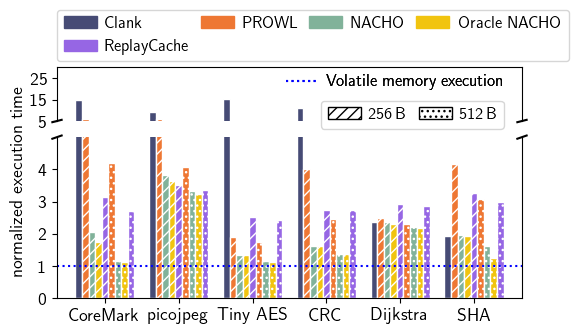

In [21]:

# Execution time plot
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 3]})
ax.set_ylim(5, 30)
ax2.set_ylim(0, 5)

configureBrokenPlot(ax, ax2)

dfn.T.plot(kind='bar', ax=ax, legend=None, width=0.8, color=color_list, edgecolor='white', linewidth=1)
dfn.T.plot(kind='bar', ax=ax2, legend=None, width=0.8, color=color_list, edgecolor='white', linewidth=1)

applyHatches(Benchmarks, hatches_list, ax)
applyHatches(Benchmarks, hatches_list, ax2)
     
# Line at 1 (norm)
# Average for Ratchet and Opt-All
plain_c_line = ax2.axhline(y = 1.0, color = 'blue', linestyle = ':', label='Volatile memory execution', linewidth=1.5)

#
# Add custom legend (manual way)
#
 
# Config legend
configs = ['Clank', 'ReplayCache', 'PROWL','NACHO', 'Oracle NACHO']
config_colors = [ColorScheme['clank'], ColorScheme['replay_cache'], ColorScheme['prowl'], ColorScheme['nacho_pw_stcont'], ColorScheme['nacho_clank']]

legends = []

handles = []
for idx, l in enumerate(configs):
    handles.append(Patch(label=l, color=config_colors[idx]))
legend_configs = plt.legend(handles=handles, loc='lower left', ncol=4, bbox_to_anchor = (-0.018, 1.42), 
                            fancybox=True, fontsize=12, columnspacing=0.6, handletextpad=0.5);
ax2.add_artist(legend_configs)

# Cache legends
caches = ['256\\,B', '512\\,B']
config_hatches = [cache_256_hatch, cache_512_hatch]

# Config legend

handles = []
for idx, l in enumerate(caches):
    handles.append(Patch(label=l, hatch=config_hatches[idx], facecolor='none', edgecolor='black'))
cache_configs = plt.legend(handles=handles, loc='lower left', ncol=2, bbox_to_anchor = (0.55, 1), 
                           fancybox=True, fontsize=12, columnspacing=0.8, handletextpad=0.4);
ax2.add_artist(cache_configs)
legends.append(cache_configs)

# Normalized Plain C legend
handles = []
handles.append(plain_c_line)
cache_configs = plt.legend(handles=handles, loc='lower left', ncol=1, bbox_to_anchor = (0.46, 1.2), 
                           fancybox=True, frameon=False, fontsize=12, columnspacing=0.8, handletextpad=0.4);
ax2.add_artist(cache_configs)
legends.append(cache_configs)

# Plotting
#ax.set_ylabel("normalized execution time")
fig.text(0.06, 0.5, 'normalized execution time', ha='center', va='center', rotation='vertical')

ax.set_yticks([5, 15, 25])
ax2.set_yticks([0, 1, 2, 3, 4])

plt.subplots_adjust(hspace=0.15)

plt.xticks(rotation=0)
#plt.tight_layout()
plt.show()

In [22]:
# Save the figure
ax2.get_figure().savefig('plots/benchmark-execution-time.pdf', bbox_inches='tight')

## Power Failure Comparison

In [23]:
# Normalize
dfn = PlotDataDFPF250000.copy()

norm_config = 'plain_c-0-0'

for benchmark in Benchmarks:
    norm_value = dfn[benchmark][norm_config]
    print(norm_value)
    dfn[benchmark] = dfn[benchmark]/norm_value

adfn = dfn.copy()
dfn = dfn.drop('plain_c-0-0')

# Rename
dfn = dfn.rename(columns=BenchmarkNameMap)
dfn

2928751.0
22634204.0
8130171.0
21761.0
58583596.0
22735380.0


,CoreMark,picojpeg,Tiny AES,CRC,Dijkstra,SHA
clank-0-0-125000-250000-final,14.905546,9.160936,15.274817,11.238132,2.448487,2.514398
prowl-512-2-125000-250000-final,4.253900,4.114657,1.791561,2.453793,2.389611,3.118241
replay_cache-512-2-0-250000-final,2.756265,3.416186,2.465735,2.723726,2.888717,3.027428
nacho_pw_stcont-512-2-125000-250000-final,1.294956,3.357132,1.172571,1.364781,2.217169,1.627835


In [24]:
# Colors
color_list = []
for config in dfn.T:
    stripped_config = config.split('-')[0]
    color_list += [ColorScheme[stripped_config]]
    
color_list

['#464B75', '#ee7733', '#9666E4', '#81b29a']

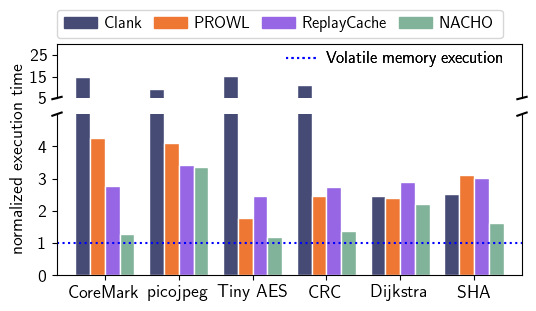

In [25]:
# Execution time plot
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 3]})
ax.set_ylim(5, 30)
ax2.set_ylim(0, 5)

configureBrokenPlot(ax, ax2)

dfn.T.plot(kind='bar', ax=ax, legend=None, width=0.8, color=color_list, edgecolor='white', linewidth=1)
dfn.T.plot(kind='bar', ax=ax2, legend=None, width=0.8, color=color_list, edgecolor='white', linewidth=1)

# applyHatches(Benchmarks, hatches_list, ax)
# applyHatches(Benchmarks, hatches_list, ax2)
     
# Line at 1 (norm)
# Average for Ratchet and Opt-All
plain_c_line = ax2.axhline(y = 1.0, color = 'blue', linestyle = ':', label='Volatile memory execution', linewidth=1.5)

#
# Add custom legend (manual way)
#
 
# Config legend
configs = ['Clank', 'PROWL', 'ReplayCache', 'NACHO']
config_colors = [ColorScheme['clank'], ColorScheme['prowl'], ColorScheme['replay_cache'], ColorScheme['nacho_pw_stcont']]

legends = []

handles = []
for idx, l in enumerate(configs):
    handles.append(Patch(label=l, color=config_colors[idx]))
legend_configs = plt.legend(handles=handles, loc='lower left', ncol=4, bbox_to_anchor = (-0.018, 1.42), 
                            fancybox=True, fontsize=12, columnspacing=0.6, handletextpad=0.5);
ax2.add_artist(legend_configs)

# Cache legends
# caches = ['256\\,B', '512\\,B']
# config_hatches = [cache_256_hatch, cache_512_hatch]

# # Config legend

# handles = []
# for idx, l in enumerate(caches):
#     handles.append(Patch(label=l, hatch=config_hatches[idx], facecolor='none', edgecolor='black'))
# cache_configs = plt.legend(handles=handles, loc='lower left', ncol=2, bbox_to_anchor = (0.55, 1), 
#                            fancybox=True, fontsize=12, columnspacing=0.8, handletextpad=0.4);
# ax2.add_artist(cache_configs)
# legends.append(cache_configs)

# Normalized Plain C legend
handles = []
handles.append(plain_c_line)
cache_configs = plt.legend(handles=handles, loc='lower left', ncol=1, bbox_to_anchor = (0.46, 1.2), 
                           fancybox=True, frameon=False, fontsize=12, columnspacing=0.8, handletextpad=0.4);
ax2.add_artist(cache_configs)
legends.append(cache_configs)

# Plotting
#ax.set_ylabel("normalized execution time")
fig.text(0.06, 0.5, 'normalized execution time', ha='center', va='center', rotation='vertical')

ax.set_yticks([5, 15, 25])
ax2.set_yticks([0, 1, 2, 3, 4])

plt.subplots_adjust(hspace=0.15)

plt.xticks(rotation=0)
#plt.tight_layout()
plt.show()

## Optimization level comparison

In [26]:
# Normalize
dfn = PlotDataDFO1.copy()

norm_config = 'plain_c-0-0-O1'

for benchmark in Benchmarks:
    norm_value = dfn[benchmark][norm_config]
    dfn[benchmark] = dfn[benchmark]/norm_value

adfn = dfn.copy()
dfn = dfn.drop('plain_c-0-0-O1')

# Rename
dfn = dfn.rename(columns=BenchmarkNameMap)
dfn

,CoreMark,picojpeg,Tiny AES,CRC,Dijkstra,SHA
clank-0-0-O1,14.298723,11.907495,21.157655,7.588555,2.351739,2.292707
prowl-512-2-O1,4.095355,4.673674,1.508678,1.834541,2.349292,3.151061
replay_cache-512-2-O1,2.676881,3.812346,2.648042,2.024575,2.912257,3.039091
nacho_pw_stcont-512-2-O1,1.151917,2.943383,1.077223,1.234748,2.174411,1.494002


In [27]:
# Colors
color_list = []
for config in dfn.T:
    stripped_config = config.split('-')[0]
    color_list += [ColorScheme[stripped_config]]
    
color_list

['#464B75', '#ee7733', '#9666E4', '#81b29a']

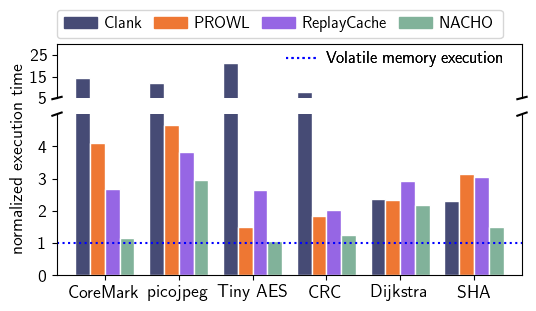

In [28]:
# Execution time plot
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 3]})
ax.set_ylim(5, 30)
ax2.set_ylim(0, 5)

configureBrokenPlot(ax, ax2)

dfn.T.plot(kind='bar', ax=ax, legend=None, width=0.8, color=color_list, edgecolor='white', linewidth=1)
dfn.T.plot(kind='bar', ax=ax2, legend=None, width=0.8, color=color_list, edgecolor='white', linewidth=1)

# applyHatches(Benchmarks, hatches_list, ax)
# applyHatches(Benchmarks, hatches_list, ax2)
     
# Line at 1 (norm)
# Average for Ratchet and Opt-All
plain_c_line = ax2.axhline(y = 1.0, color = 'blue', linestyle = ':', label='Volatile memory execution', linewidth=1.5)

#
# Add custom legend (manual way)
#
 
# Config legend
configs = ['Clank', 'PROWL', 'ReplayCache', 'NACHO']
config_colors = [ColorScheme['clank'], ColorScheme['prowl'], ColorScheme['replay_cache'], ColorScheme['nacho_pw_stcont']]

legends = []

handles = []
for idx, l in enumerate(configs):
    handles.append(Patch(label=l, color=config_colors[idx]))
legend_configs = plt.legend(handles=handles, loc='lower left', ncol=4, bbox_to_anchor = (-0.018, 1.42), 
                            fancybox=True, fontsize=12, columnspacing=0.6, handletextpad=0.5);
ax2.add_artist(legend_configs)

# Cache legends
# caches = ['256\\,B', '512\\,B']
# config_hatches = [cache_256_hatch, cache_512_hatch]

# # Config legend

# handles = []
# for idx, l in enumerate(caches):
#     handles.append(Patch(label=l, hatch=config_hatches[idx], facecolor='none', edgecolor='black'))
# cache_configs = plt.legend(handles=handles, loc='lower left', ncol=2, bbox_to_anchor = (0.55, 1), 
#                            fancybox=True, fontsize=12, columnspacing=0.8, handletextpad=0.4);
# ax2.add_artist(cache_configs)
# legends.append(cache_configs)

# Normalized Plain C legend
handles = []
handles.append(plain_c_line)
cache_configs = plt.legend(handles=handles, loc='lower left', ncol=1, bbox_to_anchor = (0.46, 1.2), 
                           fancybox=True, frameon=False, fontsize=12, columnspacing=0.8, handletextpad=0.4);
ax2.add_artist(cache_configs)
legends.append(cache_configs)

# Plotting
#ax.set_ylabel("normalized execution time")
fig.text(0.06, 0.5, 'normalized execution time', ha='center', va='center', rotation='vertical')

ax.set_yticks([5, 15, 25])
ax2.set_yticks([0, 1, 2, 3, 4])

plt.subplots_adjust(hspace=0.15)

plt.xticks(rotation=0)
#plt.tight_layout()
plt.show()

# Checkpoints

In [29]:
# Checkpoint plot

PlotBenchmarks = Benchmarks
PlotConfigurations = BaseConfigurations

EntryToPlot='checkpoint'

def getPlotData(PlotData, benchmark, config, cache):
    key = config+'-'+cache
    if key not in PlotData[benchmark]:
        PlotData[benchmark][key] = {}
        
    PlotData[benchmark][config+'-'+cache] = Results[benchmark][config][cache][EntryToPlot]
    
PlotData = {}
for benchmark in PlotBenchmarks:
    PlotData[benchmark] = {}
    
    getPlotData(PlotData, benchmark, 'clank', '0-0')

    # getPlotData(PlotData, benchmark, 'replay_cache', '256-2')
    # getPlotData(PlotData, benchmark, 'replay_cache', '512-2')
    
    getPlotData(PlotData, benchmark, 'prowl', '256-2')
    getPlotData(PlotData, benchmark, 'prowl', '512-2')
    
    getPlotData(PlotData, benchmark, 'nacho_pw_stcont', '256-2')
    getPlotData(PlotData, benchmark, 'nacho_pw_stcont', '512-2')
    
    getPlotData(PlotData, benchmark, 'nacho_clank', '256-2')
    getPlotData(PlotData, benchmark, 'nacho_clank', '512-2')
    
    
#PlotData
PlotDataDF = pd.DataFrame.from_dict(PlotData)


In [30]:
# Normalize
dfn = PlotDataDF.copy()

norm_config = 'clank-0-0'

for benchmark in PlotBenchmarks:
    norm_value = dfn[benchmark][norm_config]
    dfn[benchmark] = dfn[benchmark]/norm_value

# Rename
dfn = dfn.rename(columns=BenchmarkNameMap)
dfn

,CoreMark,picojpeg,Tiny AES,CRC,Dijkstra,SHA
clank-0-0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
prowl-256-2,0.242211,0.452642,0.036135,0.214559,0.387886,211.021622
prowl-512-2,0.141186,0.255753,0.020423,0.084291,0.211731,105.610811
nacho_pw_stcont-256-2,0.034472,0.309447,0.014526,0.022989,0.739390,39.735135
nacho_pw_stcont-512-2,0.003555,0.262650,0.006674,0.011494,0.600000,19.956757
nacho_clank-256-2,0.018443,0.285732,0.013349,0.022989,0.701591,39.513514
nacho_clank-512-2,0.002952,0.251511,0.005104,0.011494,0.577995,6.800000


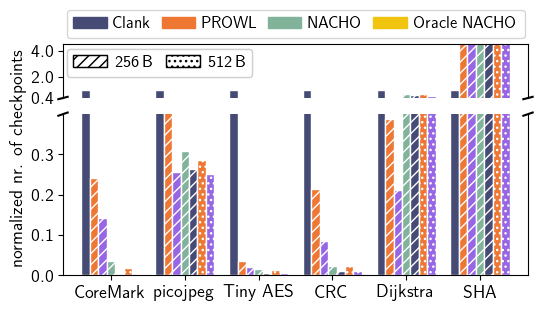

In [31]:
# Checkpoint plot

# Two plots for broken Y axis
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 3]})
ax.set_ylim(0.4, 4.5)
ax2.set_ylim(0, 0.4)

configureBrokenPlot(ax, ax2)

bottom = dfn.T.plot(ax=ax2, kind='bar', legend=None, width=0.8, color=color_list, edgecolor='white', linewidth=1)
top = dfn.T.plot(ax=ax, logy=False, kind='bar', legend=None, width=0.8, color=color_list, edgecolor='white', linewidth=1)

applyHatches(Benchmarks, hatches_list, ax)
applyHatches(Benchmarks, hatches_list, ax2)

#
# Add custom legend (manual way)
#
 
# Config legend
configs = ['Clank', 'PROWL','NACHO', 'Oracle NACHO']
config_colors = [ColorScheme['clank'], ColorScheme['prowl'], ColorScheme['nacho_pw_stcont'], ColorScheme['nacho_clank']]

handles = []
for idx, l in enumerate(configs):
    handles.append(Patch(label=l, color=config_colors[idx]))
legend_configs = plt.legend(handles=handles, loc='lower left', ncol=4, bbox_to_anchor = (-0.01, 1.42), 
                            fancybox=True, fontsize=12, columnspacing=0.6, handletextpad=0.4);
ax2.add_artist(legend_configs)

# Cache legends
caches = ['256\\,B', '512\\,B']
config_hatches = [cache_256_hatch, cache_512_hatch]

# Config legend
handles = []
for idx, l in enumerate(caches):
    handles.append(Patch(label=l, hatch=config_hatches[idx], facecolor='none', edgecolor='black'))
cache_configs = plt.legend(handles=handles, loc='lower left', ncol=2, bbox_to_anchor = (-0.01, 1.18), 
                           fancybox=True, fontsize=12, columnspacing=0.8, handletextpad=0.5);
ax2.add_artist(cache_configs)

# Plotting
fig.text(0.05, 0.5, 'normalized nr. of checkpoints', ha='center', va='center', rotation='vertical')

ax.set_yticks([0.4, 2 ,4])
ax2.set_yticks([0, 0.1, 0.2, 0.3])


plt.xticks(rotation=0)
plt.subplots_adjust(hspace=0.15)
plt.show()

In [32]:
# Save the figure
ax2.get_figure().savefig('plots/benchmark-checkpoints.pdf', bbox_inches='tight')

# Volatile (Cache) Accesses

In [33]:
cache_size = '512-2'
Entries = [
    'cache_read',
    'cache_write',
    'cache_cuckoo',
    'cache_checkpoint'
]

PlotBenchmarks = Benchmarks
PlotConfigurations = [
    'prowl',
    'replay_cache',
    'nacho_pw_stcont',
    'nacho_clank'
]

NormConfig = 'nacho_pw_stcont'

# Normalize per benchmark to nacho_clank total number
NormValue = {}
for benchmark in Benchmarks:
    NormValue[benchmark] = 0
    for entry in Entries:
        NormValue[benchmark] += Results[benchmark][NormConfig][cache_size][entry]

def getPlotData(PlotData, entry, benchmark, config, cache):
    if config not in PlotData[entry][benchmark]:
        PlotData[entry][benchmark][config] = {}
    PlotData[entry][benchmark][config] = Results[benchmark][config][cache][entry] / NormValue[benchmark]


PlotData = {}
for entry in Entries:
    PlotData[entry] = {}
    
    for benchmark in PlotBenchmarks:
        PlotData[entry][benchmark] = {}
        
        #getPlotData(PlotData, entry, benchmark, 'clank', '0-0')
        getPlotData(PlotData, entry, benchmark, 'prowl', cache_size)
        getPlotData(PlotData, entry, benchmark, 'replay_cache', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_pw_stcont', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_clank', cache_size)
    
#PlotData
PlotDataDF = {}
for entry in Entries:
    PlotDataDF[entry] = pd.DataFrame.from_dict(PlotData[entry]).rename(columns=BenchmarkNameMap)

print('cache_read')
print(PlotDataDF['cache_read'])

print('cache_write')
print(PlotDataDF['cache_write'])

print('cache_checkpoint')
print(PlotDataDF['cache_checkpoint'])

print('cache_cuckoo')
print(PlotDataDF['cache_cuckoo'])

cache_read
                 CoreMark  picojpeg  Tiny AES       CRC  Dijkstra       SHA
prowl            0.770690  0.601183  0.639946  0.377338  0.497435  0.683203
replay_cache     0.647936  0.449636  0.703115  0.374820  0.404203  0.625894
nacho_pw_stcont  0.651849  0.508997  0.482592  0.371043  0.490748  0.644473
nacho_clank      0.651849  0.508997  0.482592  0.371043  0.490748  0.644473
cache_write
                 CoreMark  picojpeg  Tiny AES       CRC  Dijkstra       SHA
prowl            0.740235  0.611973  0.665510  0.554856  0.513053  0.397296
replay_cache     0.301744  0.284889  0.629883  0.509532  0.024071  0.203113
nacho_pw_stcont  0.323366  0.383541  0.443568  0.509532  0.487797  0.254270
nacho_clank      0.323366  0.383541  0.443568  0.509532  0.487797  0.254270
cache_checkpoint
                 CoreMark  picojpeg  Tiny AES       CRC  Dijkstra       SHA
prowl            0.093516  0.111527  0.101595  0.226619  0.018113  0.179040
replay_cache     0.000000  0.000000  0.000000  0

In [34]:
# Overhead difference for Volatile accesses
OverheadMem = PlotDataDF['cache_read'] + PlotDataDF['cache_write'] + PlotDataDF['cache_checkpoint'] + PlotDataDF['cache_cuckoo']

print('Difference cache memory')
print(OverheadMem)

# Difference in perc between nacho and prowl
OverheadNacho = (OverheadMem.T['nacho_pw_stcont']-OverheadMem)/OverheadMem*100

print('')
print('Overhead difference Nacho comapred to Prowl')
print(OverheadNacho.T['prowl'])
print('Avg:',OverheadNacho.T['prowl'].mean())
print('Max:',OverheadNacho.T['prowl'].min()) 

print('')
print('Overhead difference Nacho comapred to Nacho Oracle')
print(OverheadNacho.T['nacho_clank'])
print('Avg:',OverheadNacho.T['nacho_clank'].mean())
print('Max:',OverheadNacho.T['nacho_clank'].min()) 

print('')
print('Overhead difference Nacho comapred to ReplayCache')
print(OverheadNacho.T['replay_cache'])
print('Avg:',OverheadNacho.T['replay_cache'].mean())
print('Max:',OverheadNacho.T['replay_cache'].min()) 

Difference cache memory
                 CoreMark  picojpeg  Tiny AES       CRC  Dijkstra       SHA
prowl            3.586894  3.393499  3.130006  2.322122  2.150625  2.822161
replay_cache     0.949680  0.734525  1.332998  0.884353  0.428274  0.829007
nacho_pw_stcont  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
nacho_clank      0.996040  0.992819  1.002520  1.000000  0.998675  0.924618

Overhead difference Nacho comapred to Prowl
CoreMark   -72.120729
picojpeg   -70.531894
Tiny AES   -68.051178
CRC        -56.935946
Dijkstra   -53.501896
SHA        -64.566165
Name: prowl, dtype: float64
Avg: -64.28463478732844
Max: -72.12072923889477

Overhead difference Nacho comapred to Nacho Oracle
CoreMark    0.397614
picojpeg    0.723308
Tiny AES   -0.251364
CRC         0.000000
Dijkstra    0.132686
SHA         8.152822
Name: nacho_clank, dtype: float64
Avg: 1.5258442134101269
Max: -0.25136446008402713

Overhead difference Nacho comapred to ReplayCache
CoreMark      5.298677
picojpe

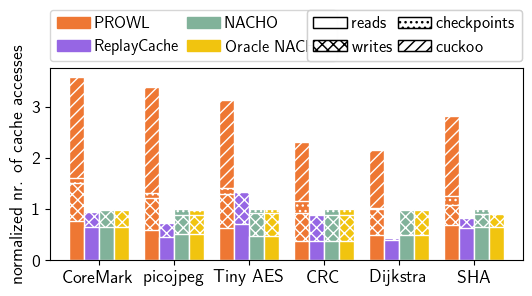

In [35]:
BarStack = [
    'cache_read',
    'cache_write',
    'cache_checkpoint',
    'cache_cuckoo'
]

HatchMap = {
    'cache_read': '',
    'cache_write': 'xxx',
    'cache_checkpoint': '...',
    'cache_cuckoo': '///'
}

# Colors
color_list = []
for config in PlotConfigurations:
    color_list += [ColorScheme[config]]
    
fig = plt.figure(figsize=(6.1, 2.5))
ax = fig.add_subplot(111)

def patchwork(ax, hatch):
    for bar in ax.patches:
        if bar.get_hatch() == None: 
            bar.set_hatch(hatch)

def plot_bar(N):
    D = PlotDataDF[BarStack[0]]
    for n in range(1, N+1):
        D = D + PlotDataDF[BarStack[n]]
        
    #D.T.plot(kind='bar', ax=ax2, width=0.8, color=color_list, edgecolor='white', legend=None, linewidth=1)
    D.T.plot(kind='bar', ax=ax, width=0.8, color=color_list, edgecolor='white', legend=None, linewidth=1)

    #patchwork(ax2, HatchMap[BarStack[N]])
    patchwork(ax, HatchMap[BarStack[N]])


# Plot the overlapping bars
plot_bar(3)
plot_bar(2)
plot_bar(1)
plot_bar(0)

# Custom legend
configs = ['PROWL', 'ReplayCache','NACHO', 'Oracle NACHO']
config_colors = [ColorScheme['prowl'], ColorScheme["replay_cache"], ColorScheme['nacho_pw_stcont'], ColorScheme['nacho_clank']]

handles = []
for idx, l in enumerate(configs):
    handles.append(Patch(label=l, color=config_colors[idx]))
    
legend_configs = plt.legend(handles=handles, loc='lower left', ncol=2, bbox_to_anchor = (-0.018, 0.99), 
                            fancybox=True, fontsize=12, columnspacing=0.4, handletextpad=0.3);
ax.add_artist(legend_configs)

handles = []
hlw=1
handles.append(Patch(label='reads', hatch=HatchMap['cache_read'],
                     facecolor='none', edgecolor='black', linewidth=hlw))
handles.append(Patch(label='writes', hatch=HatchMap['cache_write'],
                     facecolor='none', edgecolor='black', linewidth=hlw))
handles.append(Patch(label='checkpoints', hatch=HatchMap['cache_checkpoint'],
                     facecolor='none', edgecolor='black', linewidth=hlw))
handles.append(Patch(label='cuckoo', hatch=HatchMap['cache_cuckoo'],
                     facecolor='none', edgecolor='black', linewidth=hlw))

legend_configs = plt.legend(handles=handles, loc='lower left', ncol=2, bbox_to_anchor = (0.525, 0.99), 
                            fancybox=True, fontsize=12, columnspacing=0.4, handletextpad=0.3);
ax.add_artist(legend_configs)



# Show the plot
plt.xticks(rotation=0)
#plt.tight_layout()

#fig.text(-0.01, 0.5, 'normalized nr. of cache accesses', ha='center', va='center', rotation='vertical')
ax.set_ylabel('normalized nr. of cache accesses')

#ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_yticks([0, 1, 2, 3])
#ax2.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0,])
plt.show()

In [36]:
# Save the figure
ax.get_figure().savefig('plots/benchmark-volatile-accesses.pdf', bbox_inches='tight')

# NVM Access

In [37]:
# Checkpoint plot
cache_size = '512-2'
Entries = [
    'nvm_writes',
    'nvm_reads',
]

PlotBenchmarks = Benchmarks
PlotConfigurations = [
    'clank',
    'replay_cache',
    'prowl',
    'nacho_pw_stcont',
    'nacho_clank',
]


NormConfig = 'clank'

# Normalize per benchmark to nacho_clank total number
NormValue = {}
for benchmark in Benchmarks:
    NormValue[benchmark] = 0
    for entry in Entries:
        NormValue[benchmark] += Results[benchmark][NormConfig]['0-0'][entry]

def getPlotData(PlotData, entry, benchmark, config, cache):
    if config not in PlotData[entry][benchmark]:
        PlotData[entry][benchmark][config] = {}
    PlotData[entry][benchmark][config] = Results[benchmark][config][cache][entry] / NormValue[benchmark]


PlotData = {}
for entry in Entries:
    PlotData[entry] = {}
    
    for benchmark in PlotBenchmarks:
        PlotData[entry][benchmark] = {}
        
        getPlotData(PlotData, entry, benchmark, 'clank', '0-0')
        getPlotData(PlotData, entry, benchmark, 'replay_cache', cache_size)
        getPlotData(PlotData, entry, benchmark, 'prowl', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_pw_stcont', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_clank', cache_size)
    
#PlotData
PlotDataDF = {}
for entry in Entries:
    PlotDataDF[entry] = pd.DataFrame.from_dict(PlotData[entry]).rename(columns=BenchmarkNameMap)


PlotDataDF['nvm_writes']

,CoreMark,picojpeg,Tiny AES,CRC,Dijkstra,SHA
clank,0.640538,0.641414,0.656501,0.661815,0.350500,0.248031
replay_cache,0.022184,0.064184,0.029545,0.033865,0.022768,0.332310
prowl,0.103318,0.185816,0.021199,0.077847,0.102861,0.949459
nacho_pw_stcont,0.005899,0.184890,0.009948,0.019731,0.237025,0.351196
nacho_clank,0.005161,0.177197,0.009268,0.019731,0.228478,0.122818


In [38]:
# Overhead difference for NVM accesses
OverheadMem = PlotDataDF['nvm_writes'] + PlotDataDF['nvm_reads']

print('Difference NVM memory')
print(OverheadMem)

# Difference in perc between nacho and prowl
OverheadNacho = (OverheadMem.T['nacho_pw_stcont']-OverheadMem)/OverheadMem*100

print('')
print('Overhead difference Nacho comapred to Prowl')
print(OverheadNacho.T['prowl'])
print('Avg:',OverheadNacho.T['prowl'].mean())
print('Max:',OverheadNacho.T['prowl'].min()) 

print('')
print('Overhead difference Nacho comapred to Clank')
print(OverheadNacho.T['clank'])
print('Avg:',OverheadNacho.T['clank'].mean())
print('Max:',OverheadNacho.T['clank'].min()) 

print('')
print('Overhead difference Nacho comapred to ReplayCache')
print(OverheadNacho.T['replay_cache'])
print('Avg:',OverheadNacho.T['replay_cache'].mean())
print('Max:',OverheadNacho.T['replay_cache'].min()) 

print('')
print('Overhead difference Nacho comapred to Nacho Oracle')
print(OverheadNacho.T['nacho_clank'])
print('Avg:',OverheadNacho.T['nacho_clank'].mean())
print('Max:',OverheadNacho.T['nacho_clank'].min()) 



Difference NVM memory
                 CoreMark  picojpeg  Tiny AES       CRC  Dijkstra       SHA
clank            1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
replay_cache     0.023517  0.073974  0.030425  0.039919  0.346262  0.401005
prowl            0.186987  0.325719  0.042302  0.125201  0.573549  1.686434
nacho_pw_stcont  0.011352  0.294903  0.015704  0.035336  0.751719  0.611197
nacho_clank      0.010149  0.283003  0.014617  0.035336  0.738410  0.261038

Overhead difference Nacho comapred to Prowl
CoreMark   -93.928800
picojpeg    -9.460849
Tiny AES   -62.876727
CRC        -71.776504
Dijkstra    31.064448
SHA        -63.758013
Name: prowl, dtype: float64
Avg: -45.12274099567926
Max: -93.92880004456698

Overhead difference Nacho comapred to Clank
CoreMark   -98.864763
picojpeg   -70.509684
Tiny AES   -98.429600
CRC        -96.466399
Dijkstra   -24.828077
SHA        -38.880279
Name: clank, dtype: float64
Avg: -71.32980016715695
Max: -98.86476269393228

Overhead differ

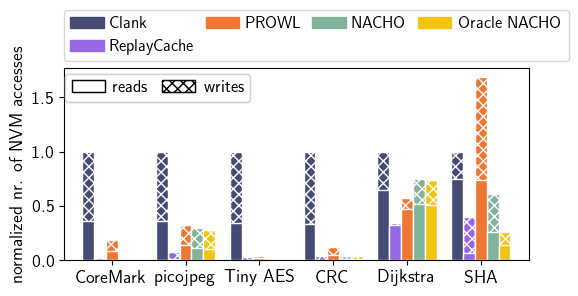

In [39]:
BarStack = [
    'nvm_reads',
    'nvm_writes',
]

HatchMap = {
    'nvm_reads': '',
    'nvm_writes': 'xxx',
}

# Colors
color_list = []
for config in PlotConfigurations:
    color_list += [ColorScheme[config]]
    
#fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 4), gridspec_kw={'height_ratios': [1, 2.5]})
ax = plt.figure(figsize=(6, 2.5)).add_subplot(111)

def patchwork(ax, hatch):
    for bar in ax.patches:
        if bar.get_hatch() == None: 
            bar.set_hatch(hatch)

def plot_bar(N):
    D = PlotDataDF[BarStack[0]]
    for n in range(1, N+1):
        D = D + PlotDataDF[BarStack[n]]
        
    D.T.plot(kind='bar', ax=ax, width=0.8, color=color_list, edgecolor='white', legend=None, linewidth=1)
    patchwork(ax, HatchMap[BarStack[N]])


# Plot the overlapping bars
plot_bar(1)
plot_bar(0)

# Custom legend
configs = ['Clank', 'ReplayCache', 'PROWL','NACHO', 'Oracle NACHO']
config_colors = [ColorScheme['clank'], ColorScheme['replay_cache'], ColorScheme['prowl'], ColorScheme['nacho_pw_stcont'], ColorScheme['nacho_clank']]

handles = []
for idx, l in enumerate(configs):
    handles.append(Patch(label=l, color=config_colors[idx]))
legend_configs = plt.legend(handles=handles, loc='lower left', ncol=4, bbox_to_anchor = (-0.018, 0.99), 
                            fancybox=True, fontsize=12, columnspacing=0.6, handletextpad=0.4);
ax.add_artist(legend_configs)

handles = []
hlw=1
handles.append(Patch(label='reads', hatch=HatchMap['nvm_reads'],
                     facecolor='none', edgecolor='black', linewidth=hlw))
handles.append(Patch(label='writes', hatch=HatchMap['nvm_writes'],
                     facecolor='none', edgecolor='black', linewidth=hlw))

legend_configs = plt.legend(handles=handles, loc='lower left', ncol=2, bbox_to_anchor = (-0.015, 0.78), 
                            fancybox=True, fontsize=12, columnspacing=0.8, handletextpad=0.5);
ax.add_artist(legend_configs)

# Show the plot
plt.xticks(rotation=0)
#plt.tight_layout(pad=0.3)

#ax.set_ylim(0,0.2)

ax.set_ylabel("normalized nr. of NVM accesses")

#ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.show()

In [40]:
# Save the figure
ax.get_figure().savefig('plots/benchmark-non-volatile-accesses.pdf', bbox_inches='tight')

# Impact of Different Components of NACHO

In [41]:
#Results

In [42]:
# Checkpoint plot
cache_size = '512-2'
Entries = [
    'cycles',
    'checkpoint',
    'nvm_reads',
    'nvm_writes',
]

NormConfig = 'nacho_naive'

def getPlotData(PlotData, entry, benchmark, config, cache):
    if config not in PlotData[entry][benchmark]:
        PlotData[entry][benchmark][config] = {}
        
    #PlotData[entry][benchmark][config] = -1*(1-(Results[benchmark][config][cache][entry] / Results[benchmark][NormConfig][cache][entry]))
    try:
        PlotData[entry][benchmark][config] = Results[benchmark][config][cache][entry]
    except:
        PlotData[entry][benchmark][config] = 0.0


PlotData = {}
for entry in Entries:
    PlotData[entry] = {}
    
    for benchmark in PlotBenchmarks:
        PlotData[entry][benchmark] = {}
        getPlotData(PlotData, entry, benchmark, 'plain_c', '0-0')

        getPlotData(PlotData, entry, benchmark, 'nacho_naive', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_pw', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_stcont', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_pw_stcont', cache_size)   
        
#PlotData
PlotDataDF = {}
for entry in Entries:
    PlotDataDF[entry] = pd.DataFrame.from_dict(PlotData[entry])

# Compute the overhead
PlotDataDF['overhead'] = PlotDataDF['cycles'] - PlotDataDF['cycles'].T['plain_c']

#print(PlotDataDF['overhead'])

# Normalize everything
for entry in PlotDataDF:
    PlotDataDF[entry] = PlotDataDF[entry] / PlotDataDF[entry].T[NormConfig]

for entry in PlotDataDF:
    print(entry)
    print(PlotDataDF[entry])
    print()

cycles
                 coremark  picojpeg       aes       crc  dijkstra       sha
plain_c          0.844291  0.290333  0.821605  0.622864  0.443869  0.562888
nacho_naive      1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
nacho_pw         0.976635  0.971195  0.979901  0.906632  0.979056  0.904661
nacho_stcont     0.998036  0.991743  0.960556  0.983628  0.999321  0.999985
nacho_pw_stcont  0.974746  0.968949  0.945620  0.850073  0.978498  0.904645

checkpoint
                 coremark  picojpeg       aes  crc  dijkstra       sha
plain_c          0.000000  0.000000  0.000000  0.0  0.000000  0.000000
nacho_naive      1.000000  1.000000  1.000000  1.0  1.000000  1.000000
nacho_pw         0.767442  0.960592  0.862852  0.6  0.919030  0.757178
nacho_stcont     1.000000  0.993227  0.864668  1.0  0.999589  1.000000
nacho_pw_stcont  0.767442  0.960336  0.772025  0.6  0.918971  0.757178

nvm_reads
                 coremark  picojpeg       aes       crc  dijkstra       sha
plain_c     

In [43]:
# Create the latex table holding all the info

Configurations = [
    'nacho_pw',
    'nacho_stcont',
    'nacho_pw_stcont'
]

Entries = [
    'overhead',
    'checkpoint',
    'nvm_reads',
    'nvm_writes',
]

EntryNameMap = {
    'overhead' : 'overhead',
    'checkpoint' : 'checkpoints',
    'nvm_reads' : 'NVM reads',
    'nvm_writes' : 'NVM writes',
}

Format = '{:.0f}'

def convertResult(val):
    return 100-(val * 100);

def toStr(val):
    s = Format.format(val)
    if val < 10:
        s = r'\hphantom{0}' + s
    return s
    
def colorbox(exec_val, t):
    #return t
    perc = exec_val+30
    return r'\colorbox{hightlight!'+str(int(perc))+r'!white}{'+t+r'}'

tex=''
def tex_addl(t):
    global tex
    tex += t + '\n'
    
def tex_add(t):
    global tex
    tex += t
  
tex_addl(r'% table automatically generated by PowertracePlot.ipynb')

tex_addl(r'\begin{tabular}{@{}l|ccccccccccccccccccc@{}}')
tex_addl(r'\toprule')

# Add the benchmark headers
#tex_add(r'test')
for bench in Benchmarks:
    tex_add(r' & \multicolumn{3}{c}{\textbf{\textsf{'+BenchmarkNameMap[bench]+'}}}')
tex_addl(r' \\ \midrule')

# Add the power-fail header
tex_add(r'\textbf{Metric}')
for bench in Benchmarks:
    tex_add(r' & \textbf{\textsf{PW}} & \textbf{\textsf{ST}} & \textbf{\textsf{N}}')
tex_addl(r' \\')

for entry in Entries:
    tex_add(EntryNameMap[entry])
    for bench in Benchmarks:
        pw_val = convertResult(PlotDataDF[entry][bench]['nacho_pw'])
        st_val = convertResult(PlotDataDF[entry][bench]['nacho_stcont'])
        pwst_val = convertResult(PlotDataDF[entry][bench]['nacho_pw_stcont'])
        
        pw_val_str = toStr(pw_val)
        st_val_str = toStr(st_val)
        pwst_val_str = toStr(pwst_val)
        
        tex_add(r' & '+pw_val_str+r'\%')
        tex_add(r' & '+st_val_str+r'\%')
        tex_add(r' & \textbf{'+colorbox(pwst_val,pwst_val_str+r'\%}'))
    tex_addl(r' \\')

# Close the table
tex_addl(r' \bottomrule')
tex_addl(r'\end{tabular}')

print(tex)

# Save the table
with open('tables/benchmarks-component-overhead.tex', "w") as f:
    # Writing data to a file
    f.write(tex)

% table automatically generated by PowertracePlot.ipynb
\begin{tabular}{@{}l|ccccccccccccccccccc@{}}
\toprule
 & \multicolumn{3}{c}{\textbf{\textsf{CoreMark}}} & \multicolumn{3}{c}{\textbf{\textsf{picojpeg}}} & \multicolumn{3}{c}{\textbf{\textsf{Tiny AES}}} & \multicolumn{3}{c}{\textbf{\textsf{CRC}}} & \multicolumn{3}{c}{\textbf{\textsf{Dijkstra}}} & \multicolumn{3}{c}{\textbf{\textsf{SHA}}} \\ \midrule
\textbf{Metric} & \textbf{\textsf{PW}} & \textbf{\textsf{ST}} & \textbf{\textsf{N}} & \textbf{\textsf{PW}} & \textbf{\textsf{ST}} & \textbf{\textsf{N}} & \textbf{\textsf{PW}} & \textbf{\textsf{ST}} & \textbf{\textsf{N}} & \textbf{\textsf{PW}} & \textbf{\textsf{ST}} & \textbf{\textsf{N}} & \textbf{\textsf{PW}} & \textbf{\textsf{ST}} & \textbf{\textsf{N}} & \textbf{\textsf{PW}} & \textbf{\textsf{ST}} & \textbf{\textsf{N}} \\
overhead & 15\% & \hphantom{0}1\% & \textbf{\colorbox{hightlight!46!white}{16\%}} & \hphantom{0}4\% & \hphantom{0}1\% & \textbf{\colorbox{hightlight!34!white}{\hphant

## Comparison of ReplayCache with WT-vCache from the ReplayCache paper

In [44]:
PlotBenchmarks = ['dijkstra', 'sha']
PlotConfigurations = BaseConfigurations

EntryToPlot='cycles'

def getPlotData(PlotData, benchmark, config, cache):
    key = config+'-'+cache
    if key not in PlotData[benchmark]:
        PlotData[benchmark][key] = {}
    
    PlotData[benchmark][config+'-'+cache] = Results[benchmark][config][cache][EntryToPlot]

PlotData = {}
for benchmark in PlotBenchmarks:
    PlotData[benchmark] = {}
    getPlotData(PlotData, benchmark, 'plain_c', '0-0')
    getPlotData(PlotData, benchmark, 'replay_cache_baseline', '8192-2')
    getPlotData(PlotData, benchmark, 'replay_cache', '8192-2')
    
    
#PlotData
PlotDataDF = pd.DataFrame.from_dict(PlotData)
PlotDataDF

,dijkstra,sha
plain_c-0-0,58583596.0,22735380.0
replay_cache_baseline-8192-2,85230132.0,75699008.0
replay_cache-8192-2,84924371.0,66802767.0


In [45]:
# Normalize
dfn = PlotDataDF.copy()

norm_config = 'plain_c-0-0'

for benchmark in PlotBenchmarks:
    norm_value = dfn[benchmark][norm_config]
    dfn[benchmark] = dfn[benchmark]/norm_value

adfn = dfn.copy()
dfn = dfn.drop('plain_c-0-0')

# Rename
dfn = dfn.rename(columns=BenchmarkNameMap)
dfn

,Dijkstra,SHA
replay_cache_baseline-8192-2,1.454846,3.329569
replay_cache-8192-2,1.449627,2.938274


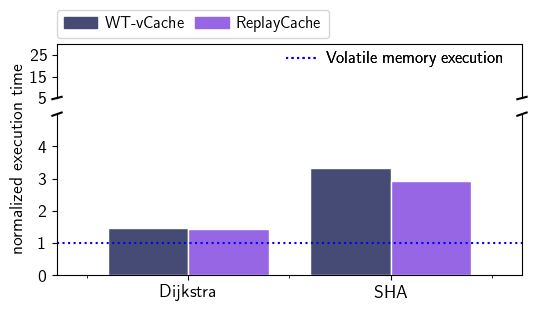

In [46]:
# Execution time plot
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 3]})
ax.set_ylim(5, 30)
ax2.set_ylim(0, 5)

configureBrokenPlot(ax, ax2)

dfn.T.plot(kind='bar', ax=ax, legend=None, width=0.8, color=color_list, edgecolor='white', linewidth=1)
dfn.T.plot(kind='bar', ax=ax2, legend=None, width=0.8, color=color_list, edgecolor='white', linewidth=1)

# applyHatches(PlotBenchmarks, hatches_list, ax)
# applyHatches(PlotBenchmarks, hatches_list, ax2)
     
# Line at 1 (norm)
# Average for Ratchet and Opt-All
plain_c_line = ax2.axhline(y = 1.0, color = 'blue', linestyle = ':', label='Volatile memory execution', linewidth=1.5)

#
# Add custom legend (manual way)
#
 
# Config legend
configs = ['WT-vCache', 'ReplayCache']
config_colors = [ColorScheme['clank'], ColorScheme['replay_cache']]

legends = []

handles = []
for idx, l in enumerate(configs):
    handles.append(Patch(label=l, color=config_colors[idx]))
legend_configs = plt.legend(handles=handles, loc='lower left', ncol=4, bbox_to_anchor = (-0.018, 1.42), 
                            fancybox=True, fontsize=12, columnspacing=0.6, handletextpad=0.5);
ax2.add_artist(legend_configs)

# Cache legends
# caches = ['8192\\,B']
# config_hatches = [cache_256_hatch]

# Config legend

# handles = []
# for idx, l in enumerate(caches):
#     handles.append(Patch(label=l, hatch=config_hatches[idx], facecolor='none', edgecolor='black'))
# cache_configs = plt.legend(handles=handles, loc='lower left', ncol=2, bbox_to_anchor = (0.55, 1), 
#                            fancybox=True, fontsize=12, columnspacing=0.8, handletextpad=0.4);
# ax2.add_artist(cache_configs)
# legends.append(cache_configs)

# Normalized Plain C legend
handles = []
handles.append(plain_c_line)
cache_configs = plt.legend(handles=handles, loc='lower left', ncol=1, bbox_to_anchor = (0.46, 1.2), 
                           fancybox=True, frameon=False, fontsize=12, columnspacing=0.8, handletextpad=0.4);
ax2.add_artist(cache_configs)
legends.append(cache_configs)

# Plotting
#ax.set_ylabel("normalized execution time")
fig.text(0.06, 0.5, 'normalized execution time', ha='center', va='center', rotation='vertical')

ax.set_yticks([5, 15, 25])
ax2.set_yticks([0, 1, 2, 3, 4])

plt.subplots_adjust(hspace=0.15)

plt.xticks(rotation=0)
#plt.tight_layout()
plt.show()